In [ ]:
#Завдання 3 --------------------------------------------------------------

In [ ]:
# Задача класифікації текстів за допомогою рекурентної нейромережі.
# https://www.kaggle.com/datasets/tafadzwaz/emotion-classify-data

In [10]:
import pandas as pd
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

# Завантаження даних
data = pd.read_csv('Emotion_classify_Data.csv', encoding='latin-1')

# Очищення тексту
def cleaning(value):
    punctuation_cleaning = []
    stopwords_cleaning_string = ''
    
    for i in value:
        if i not in string.punctuation:
            punctuation_cleaning.append(i)
    punctuation_cleaning = "".join(punctuation_cleaning).split()
    
    # Видалення стоп-слів (з використанням свого списку)
    stopwords_list = ["a", "an", "the", "in", "on", "at", "is", "it", "and", "to", "of"]
    for j in punctuation_cleaning:
        if j.lower() not in stopwords_list:
            stopwords_cleaning_string += j.lower() + ' '
    
    return stopwords_cleaning_string

data['Cleaned_Comment'] = data['Comment'].apply(cleaning)

In [11]:
# Перетворення емоцій у числовий формат
label_encoder = LabelEncoder()
data['Emotion_Label'] = label_encoder.fit_transform(data['Emotion'])

In [12]:
# Розподіл даних
X = data['Cleaned_Comment']
y = data['Emotion_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [13]:
# Токенізація тексту
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
maxlen = int(np.ceil(np.mean([len(x) for x in X_train_seq])))
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')
total_words = len(tokenizer.word_index) + 1

In [14]:
# ---- СПОСІБ 1: Навчання з нуля ---- #
print("Навчання моделі з нуля...")
model_scratch = Sequential()
model_scratch.add(Embedding(total_words, 32, input_length=maxlen))
model_scratch.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model_scratch.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_scratch.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history_scratch = model_scratch.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

Навчання моделі з нуля...
Epoch 1/10


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3593 - loss: 1.0974 - val_accuracy: 0.4811 - val_loss: 1.0730
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5759 - loss: 0.9599 - val_accuracy: 0.6463 - val_loss: 0.7575
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6874 - loss: 0.6365 - val_accuracy: 0.6895 - val_loss: 0.7236
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7668 - loss: 0.5268 - val_accuracy: 0.8221 - val_loss: 0.5610
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8863 - loss: 0.3448 - val_accuracy: 0.8347 - val_loss: 0.4783
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9336 - loss: 0.2439 - val_accuracy: 0.8358 - val_loss: 0.4891
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9609 - loss: 0.1676 - val_accuracy: 0.8368 - val_loss: 0.4842
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9753 - loss: 0.1250 - val_accuracy: 0.8347 - val

In [15]:
# ---- СПОСІБ 2: Використання pretrained embeddings ---- #
print("Завантаження pretrained embeddings...")
embedding_dim = 50
embedding_matrix = np.zeros((total_words, embedding_dim))
# Замість GloVe, ініціалізуємо випадкові вектори для прикладу
for word, i in tokenizer.word_index.items():
    if i < total_words:
        embedding_matrix[i] = np.random.rand(embedding_dim)

Завантаження pretrained embeddings...


In [16]:
model_pretrained = Sequential()
model_pretrained.add(Embedding(
    total_words,
    embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False  # Заморожуємо попередньо навчені вектори
))
model_pretrained.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model_pretrained.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_pretrained.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history_pretrained = model_pretrained.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3368 - loss: 1.1159 - val_accuracy: 0.3705 - val_loss: 1.0962
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3401 - loss: 1.1043 - val_accuracy: 0.3463 - val_loss: 1.0976
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3482 - loss: 1.0999 - val_accuracy: 0.3411 - val_loss: 1.0959
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3575 - loss: 1.0966 - val_accuracy: 0.3295 - val_loss: 1.0969
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3523 - loss: 1.0971 - val_accuracy: 0.3568 - val_loss: 1.0962
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3458 - loss: 1.0996 - val_accuracy: 0.3663 - val_loss: 1.0968
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3484 - loss: 1.1001 - val_accuracy: 0.3442 - val_loss: 1.0973
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3607 - loss: 1.0962 - val_accuracy: 0

In [17]:
# ---- Порівняння результатів ---- #
print("Оцінка моделі з нуля:")
results_scratch = model_scratch.evaluate(X_test_pad, y_test, verbose=0)
print(f"Loss: {results_scratch[0]}, Accuracy: {results_scratch[1]}")

print("Оцінка моделі з pretrained embeddings:")
results_pretrained = model_pretrained.evaluate(X_test_pad, y_test, verbose=0)
print(f"Loss: {results_pretrained[0]}, Accuracy: {results_pretrained[1]}")

Оцінка моделі з нуля:
Loss: 0.4527382254600525, Accuracy: 0.8611111044883728
Оцінка моделі з pretrained embeddings:
Loss: 1.1007792949676514, Accuracy: 0.3392255902290344


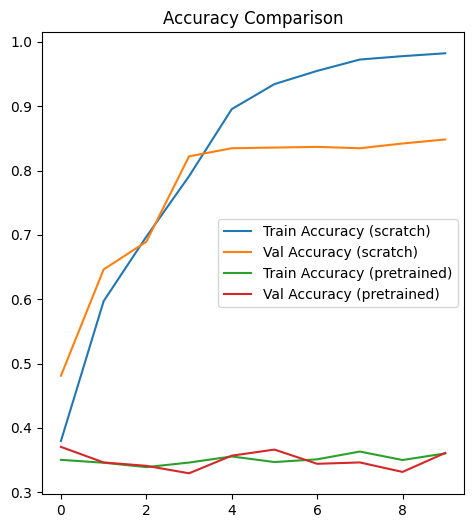

In [18]:
# ---- Візуалізація результатів ---- #
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['accuracy'], label='Train Accuracy (scratch)')
plt.plot(history_scratch.history['val_accuracy'], label='Val Accuracy (scratch)')
plt.plot(history_pretrained.history['accuracy'], label='Train Accuracy (pretrained)')
plt.plot(history_pretrained.history['val_accuracy'], label='Val Accuracy (pretrained)')
plt.title('Accuracy Comparison')
plt.legend()

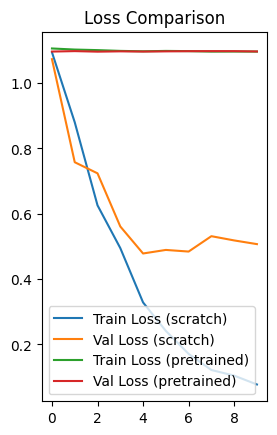

In [19]:
plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['loss'], label='Train Loss (scratch)')
plt.plot(history_scratch.history['val_loss'], label='Val Loss (scratch)')
plt.plot(history_pretrained.history['loss'], label='Train Loss (pretrained)')
plt.plot(history_pretrained.history['val_loss'], label='Val Loss (pretrained)')
plt.title('Loss Comparison')
plt.legend()

plt.show()